## Dataset:
The Online Retail a transactional data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

Link tp dataset: https://archive.ics.uci.edu/ml/datasets/online+retail

But first, let's see some deep understand an important Concept

## Customer segmentation: 

Customer segmentation is the problem of uncovering information about a firm's customer base, based on their interactions with the business. In most cases this interaction is in terms of their purchase behavior and patterns. We explore some of the ways in which this can be used. This is used to gain insights into granular behavior of customers. This is helpful in devising strategies which uncovers deeper understanding of purchase decisions taken by the customers. This is interesting as a lot of times even the customer will be unaware of such biases or trends in their purchasing behavior.

## Necessary Imports

In [4]:
import os
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
    pass

warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

import pandas as pd
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.cm as cm

%matplotlib inline

import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
color = sns.color_palette()
sns.set_style('darkgrid')

from mpl_toolkits.mplot3d import Axes3D



from scipy import stats
from scipy.stats import skew, norm, probplot, boxcox
from sklearn import preprocessing
import math

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score


## Load File

In [5]:
cs_df = pd.read_excel('Online Retail.xlsx')

In [6]:
cs_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Stats of Data

In [7]:
def rstr(df, pred=None): 
    obs = df.shape[0]
    types = df.dtypes
    counts = df.apply(lambda x: x.count())
    uniques = df.apply(lambda x: [x.unique()])
    nulls = df.apply(lambda x: x.isnull().sum())
    distincts = df.apply(lambda x: x.unique().shape[0])
    missing_ration = (df.isnull().sum()/ obs) * 100
    skewness = df.skew()
    kurtosis = df.kurt() 
    print('Data shape:', df.shape)
    
    if pred is None:
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing ration', 'uniques', 'skewness', 'kurtosis']
        str = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis], axis = 1)

    else:
        corr = df.corr()[pred]
        str = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis, corr], axis = 1)
        corr_col = 'corr '  + pred
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing ration', 'uniques', 'skewness', 'kurtosis', corr_col ]
    
    str.columns = cols
    dtypes = str.types.value_counts()
    print('___________________________\nData types:\n',str.types.value_counts())
    print('___________________________')
    return str

details = rstr(cs_df)
display(details.sort_values(by='missing ration', ascending=False))

Data shape: (541909, 8)
___________________________
Data types:
 object            4
float64           2
int64             1
datetime64[ns]    1
Name: types, dtype: int64
___________________________


,types,counts,distincts,nulls,missing ration,uniques,skewness,kurtosis
CustomerID,float64,406829,4373,135080,24.926694,"[[17850.0, 13047.0, 12583.0, 13748.0, 15100.0,...",0.029835,-1.179982
Description,object,540455,4224,1454,0.268311,"[[WHITE HANGING HEART T-LIGHT HOLDER, WHITE ME...",NaN,NaN
Country,object,541909,38,0,0.000000,"[[United Kingdom, France, Australia, Netherlan...",NaN,NaN
InvoiceDate,datetime64[ns],541909,23260,0,0.000000,"[[2010-12-01 08:26:00, 2010-12-01 08:28:00, 20...",NaN,NaN
InvoiceNo,object,541909,25900,0,0.000000,"[[536365, 536366, 536367, 536368, 536369, 5363...",NaN,NaN
Quantity,int64,541909,722,0,0.000000,"[[6, 8, 2, 32, 3, 4, 24, 12, 48, 18, 20, 36, 8...",-0.264076,119769.160031
StockCode,object,541909,4070,0,0.000000,"[[85123A, 71053, 84406B, 84029G, 84029E, 22752...",NaN,NaN
UnitPrice,float64,541909,1630,0,0.000000,"[[2.55, 3.39, 2.75, 7.65, 4.25, 1.85, 1.69, 2....",186.506972,59005.719097


#### Let's see the description of each column:

InvoiceNo: A unique identifier for the invoice. An invoice number shared across rows means that those transactions were performed in a single invoice (multiple purchases).

StockCode: Identifier for items contained in an invoice.

Description: Textual description of each of the stock item.

Quantity: The quantity of the item purchased.

InvoiceDate: Date of purchase.

UnitPrice: Value of each item.

CustomerID: Identifier for customer making the purchase.

Country: Country of customer.

In [9]:
print('Check if we had negative quantity and prices at same register:',
     'No' if cs_df[(cs_df.Quantity<0) & (cs_df.UnitPrice<0)].shape[0] == 0 else 'Yes', '\n')
print('Check how many register we have where quantity is negative',
      'and prices is 0 or vice-versa:',
      cs_df[(cs_df.Quantity<=0) & (cs_df.UnitPrice<=0)].shape[0])
print('\nWhat is the customer ID of the registers above:',
      cs_df.loc[(cs_df.Quantity<=0) & (cs_df.UnitPrice<=0), 
                ['CustomerID']].CustomerID.unique())
print('\n% Negative Quantity: {:3.2%}'.format(cs_df[(cs_df.Quantity<0)].shape[0]/cs_df.shape[0]))
print('\nAll register with negative quantity has Invoice start with:', 
      cs_df.loc[(cs_df.Quantity<0) & ~(cs_df.CustomerID.isnull()), 'InvoiceNo'].apply(lambda x: x[0]).unique())
print('\nSee an example of negative quantity and others related records:')
display(cs_df[(cs_df.CustomerID==12472) & (cs_df.StockCode==22244)])


Check if we had negative quantity and prices at same register: No 

Check how many register we have where quantity is negative and prices is 0 or vice-versa: 1336

What is the customer ID of the registers above: [nan]

% Negative Quantity: 1.96%

All register with negative quantity has Invoice start with: ['C']

See an example of negative quantity and others related records:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1973,C536548,22244,3 HOOK HANGER MAGIC GARDEN,-4,2010-12-01 14:33:00,1.95,12472.0,Germany
9438,537201,22244,3 HOOK HANGER MAGIC GARDEN,12,2010-12-05 14:19:00,1.95,12472.0,Germany
121980,546843,22244,3 HOOK HANGER MAGIC GARDEN,12,2011-03-17 12:40:00,1.95,12472.0,Germany


We can observe from the preceding output that Quantity and UnitPrice are having negative values, which may mean that we may have some return transactions in our data also. As our goal is customer segmentation and market basket analysis, it is important that these records are removed, but first we will take a look at whether there are records where both are negative or if one of them is negative and the other is zero.

In [10]:
print('Check register with UnitPrice negative:')
display(cs_df[(cs_df.UnitPrice<0)])
print("Sales records with Customer ID and zero in Unit Price:",cs_df[(cs_df.UnitPrice==0)  & ~(cs_df.CustomerID.isnull())].shape[0])
cs_df[(cs_df.UnitPrice==0)  & ~(cs_df.CustomerID.isnull())]

Check register with UnitPrice negative:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


Sales records with Customer ID and zero in Unit Price: 40


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,2010-12-05 14:02:00,0.0,12647.0,Germany
33576,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,2010-12-16 14:36:00,0.0,16560.0,United Kingdom
40089,539722,22423,REGENCY CAKESTAND 3 TIER,10,2010-12-21 13:45:00,0.0,14911.0,EIRE
47068,540372,22090,PAPER BUNTING RETROSPOT,24,2011-01-06 16:41:00,0.0,13081.0,United Kingdom
47070,540372,22553,PLASTERS IN TIN SKULLS,24,2011-01-06 16:41:00,0.0,13081.0,United Kingdom
56674,541109,22168,ORGANISER WOOD ANTIQUE WHITE,1,2011-01-13 15:10:00,0.0,15107.0,United Kingdom
86789,543599,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,16,2011-02-10 13:08:00,0.0,17560.0,United Kingdom
130188,547417,22062,CERAMIC BOWL WITH LOVE HEART DESIGN,36,2011-03-23 10:25:00,0.0,13239.0,United Kingdom
139453,548318,22055,MINI CAKE STAND HANGING STRAWBERY,5,2011-03-30 12:45:00,0.0,13113.0,United Kingdom
145208,548871,22162,HEART GARLAND RUSTIC PADDED,2,2011-04-04 14:42:00,0.0,14410.0,United Kingdom


As you can see, there are no records where quantity and price are negative, but there are 1336 records where one of them is negative and the other is 0. However, note that for all these records we do not have the customer ID. So we conclude that we can erase all records in that quantity or the price and negative. In addition, by the foregoing summary we see that there are 135,080 records without customer identification that we may also disregard.

## Fixing Data Issues

In [11]:
# Remove register withou CustomerID
cs_df = cs_df[~(cs_df.CustomerID.isnull())]

# Remove negative or return transactions
cs_df = cs_df[~(cs_df.Quantity<0)]
cs_df = cs_df[cs_df.UnitPrice>0]

details = rstr(cs_df)
display(details.sort_values(by='distincts', ascending=False))

Data shape: (397884, 8)
___________________________
Data types:
 object            4
float64           2
int64             1
datetime64[ns]    1
Name: types, dtype: int64
___________________________


,types,counts,distincts,nulls,missing ration,uniques,skewness,kurtosis
InvoiceNo,object,397884,18532,0,0.0,"[[536365, 536366, 536367, 536368, 536369, 5363...",-0.178524,-1.200748
InvoiceDate,datetime64[ns],397884,17282,0,0.0,"[[2010-12-01 08:26:00, 2010-12-01 08:28:00, 20...",NaN,NaN
CustomerID,float64,397884,4338,0,0.0,"[[17850.0, 13047.0, 12583.0, 13748.0, 15100.0,...",0.025729,-1.180822
Description,object,397884,3877,0,0.0,"[[WHITE HANGING HEART T-LIGHT HOLDER, WHITE ME...",NaN,NaN
StockCode,object,397884,3665,0,0.0,"[[85123A, 71053, 84406B, 84029G, 84029E, 22752...",NaN,NaN
UnitPrice,float64,397884,440,0,0.0,"[[2.55, 3.39, 2.75, 7.65, 4.25, 1.85, 1.69, 2....",204.032727,58140.396673
Quantity,int64,397884,301,0,0.0,"[[6, 8, 2, 32, 3, 4, 24, 12, 48, 18, 20, 36, 8...",409.892972,178186.243253
Country,object,397884,37,0,0.0,"[[United Kingdom, France, Australia, Netherlan...",NaN,NaN


In [12]:
cat_des_df = cs_df.groupby(["StockCode","Description"]).count().reset_index()
display(cat_des_df.StockCode.value_counts()[cat_des_df.StockCode.value_counts()>1].reset_index().head())
cs_df[cs_df['StockCode'] == cat_des_df.StockCode.value_counts()[cat_des_df.StockCode.value_counts()>1]
      .reset_index()['index'][4]]['Description'].unique()

,index,StockCode
0,23236,4
1,23196,4
2,23244,3
3,17107D,3
4,23231,3


array(['WRAP DOILEY DESIGN', 'WRAP  VINTAGE DOILEY ',
       'WRAP  VINTAGE DOILY '], dtype=object)

After this first cleanup, note that we still have more description than inventory codes, so we still have some inconsistency on the basis that requires further investigation. Let´s see it:

In [13]:
cs_df.InvoiceDate = pd.to_datetime(cs_df.InvoiceDate)
cs_df['amount'] = cs_df.Quantity*cs_df.UnitPrice
cs_df.CustomerID = cs_df.CustomerID.astype('Int64')

details = rstr(cs_df)
display(details.sort_values(by='distincts', ascending=False))

Data shape: (397884, 9)
___________________________
Data types:
 object            4
float64           2
int64             1
Int64             1
datetime64[ns]    1
Name: types, dtype: int64
___________________________


,types,counts,distincts,nulls,missing ration,uniques,skewness,kurtosis
InvoiceNo,object,397884,18532,0,0.0,"[[536365, 536366, 536367, 536368, 536369, 5363...",-0.178524,-1.200748
InvoiceDate,datetime64[ns],397884,17282,0,0.0,"[[2010-12-01 08:26:00, 2010-12-01 08:28:00, 20...",NaN,NaN
CustomerID,Int64,397884,4338,0,0.0,"[[17850, 13047, 12583, 13748, 15100, 15291, 14...",0.025729,-1.180822
Description,object,397884,3877,0,0.0,"[[WHITE HANGING HEART T-LIGHT HOLDER, WHITE ME...",NaN,NaN
StockCode,object,397884,3665,0,0.0,"[[85123A, 71053, 84406B, 84029G, 84029E, 22752...",NaN,NaN
amount,float64,397884,2939,0,0.0,"[[15.299999999999999, 20.34, 22.0, 15.3, 25.5,...",451.443182,232155.117219
UnitPrice,float64,397884,440,0,0.0,"[[2.55, 3.39, 2.75, 7.65, 4.25, 1.85, 1.69, 2....",204.032727,58140.396673
Quantity,int64,397884,301,0,0.0,"[[6, 8, 2, 32, 3, 4, 24, 12, 48, 18, 20, 36, 8...",409.892972,178186.243253
Country,object,397884,37,0,0.0,"[[United Kingdom, France, Australia, Netherlan...",NaN,NaN


This gives the multiple descriptions for one of those items and we witness the simple ways in which data quality can be corrupted in any dataset. A simple spelling mistake can end up in reducing data quality and an erroneous analysis.

## EDA

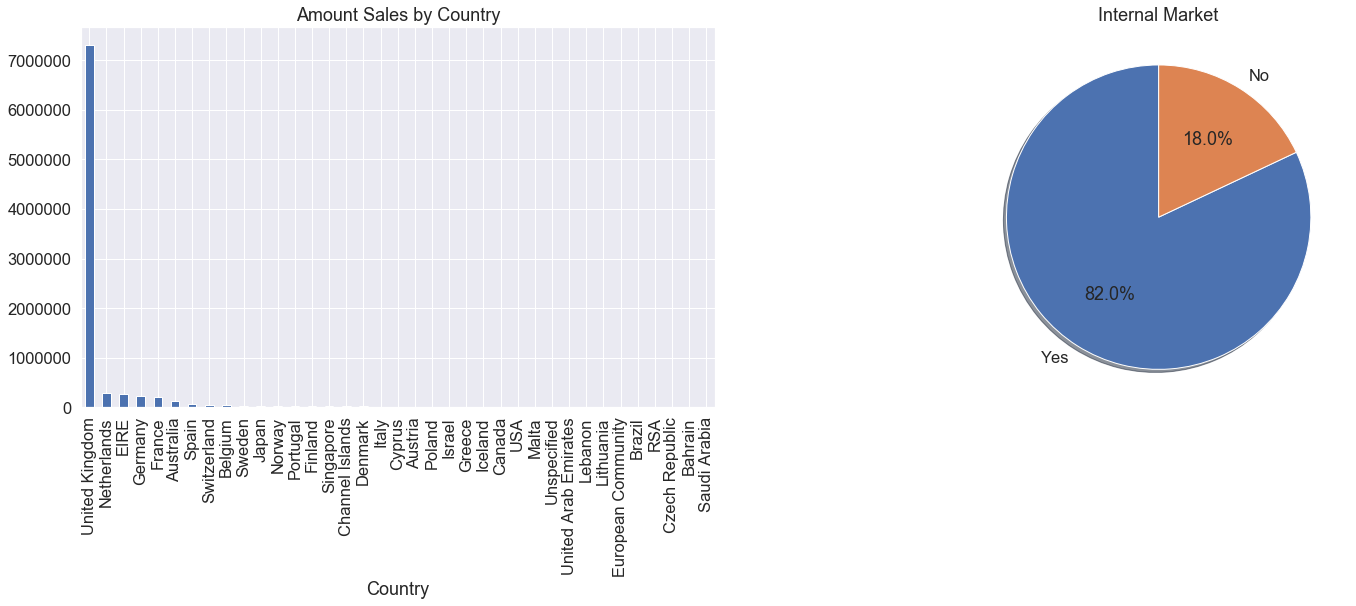

In [14]:
fig = plt.figure(figsize=(25, 7))
f1 = fig.add_subplot(121)
g = cs_df.groupby(["Country"]).amount.sum().sort_values(ascending = False).plot(kind='bar', title='Amount Sales by Country')
cs_df['Internal'] = cs_df.Country.apply(lambda x: 'Yes' if x=='United Kingdom' else 'No' )
f2 = fig.add_subplot(122)
market = cs_df.groupby(["Internal"]).amount.sum().sort_values(ascending = False)
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Internal Market')
plt.show()


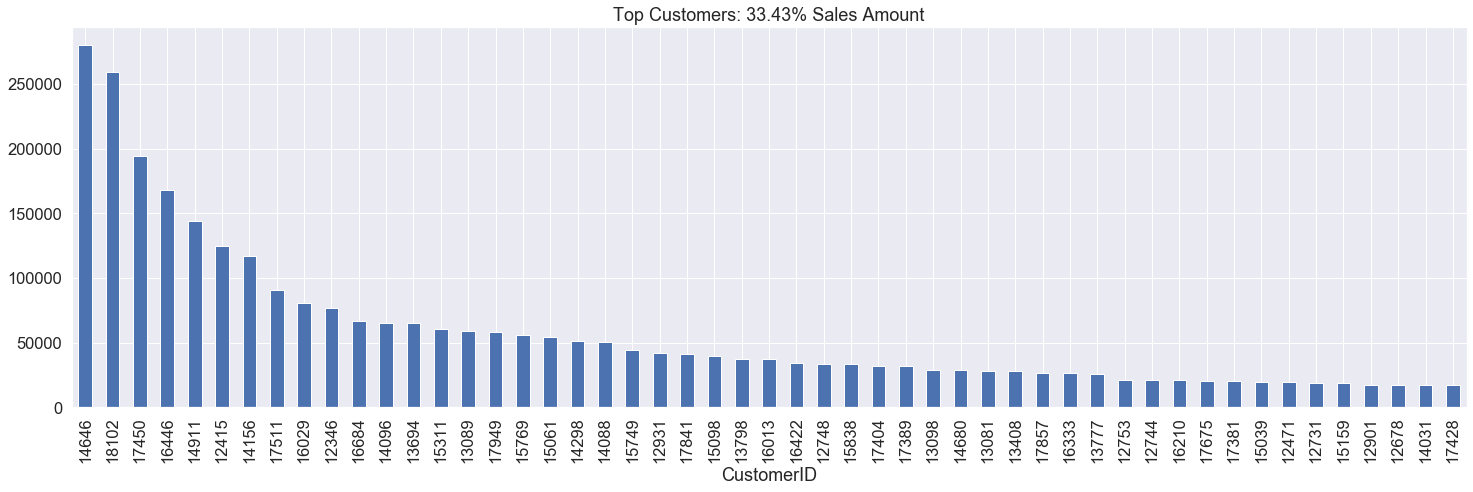

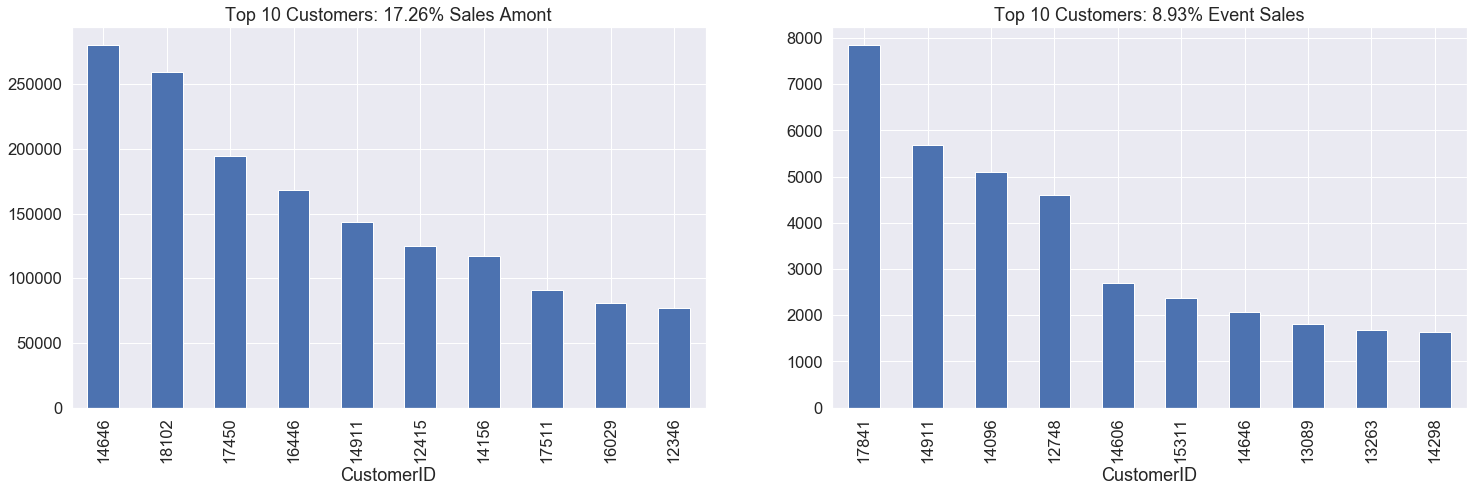

In [15]:
fig = plt.figure(figsize=(25, 7))
PercentSales =  np.round((cs_df.groupby(["CustomerID"]).amount.sum().\
                          sort_values(ascending = False)[:51].sum()/cs_df.groupby(["CustomerID"]).\
                          amount.sum().sort_values(ascending = False).sum()) * 100, 2)
g = cs_df.groupby(["CustomerID"]).amount.sum().sort_values(ascending = False)[:51].\
    plot(kind='bar', title='Top Customers: {:3.2f}% Sales Amount'.format(PercentSales))

fig = plt.figure(figsize=(25, 7))
f1 = fig.add_subplot(121)
PercentSales =  np.round((cs_df.groupby(["CustomerID"]).amount.sum().\
                          sort_values(ascending = False)[:10].sum()/cs_df.groupby(["CustomerID"]).\
                          amount.sum().sort_values(ascending = False).sum()) * 100, 2)
g = cs_df.groupby(["CustomerID"]).amount.sum().sort_values(ascending = False)[:10]\
    .plot(kind='bar', title='Top 10 Customers: {:3.2f}% Sales Amont'.format(PercentSales))
f1 = fig.add_subplot(122)
PercentSales =  np.round((cs_df.groupby(["CustomerID"]).amount.count().\
                          sort_values(ascending = False)[:10].sum()/cs_df.groupby(["CustomerID"]).\
                          amount.count().sort_values(ascending = False).sum()) * 100, 2)
g = cs_df.groupby(["CustomerID"]).amount.count().sort_values(ascending = False)[:10].\
    plot(kind='bar', title='Top 10 Customers: {:3.2f}% Event Sales'.format(PercentSales)
        )

## Customer Segmentation:
Customer segmentation is similarly the process of dividing an organization’s customer bases into different sections or segments based on various customer attributes. The process of customer segmentation is based on the premise of finding differences among the customers’ behavior and patterns.

The major objectives and benefits behind the motivation for customer segmentation are:

#### Higher Revenue:
This is the most obvious requirement of any customer segmentation project.
#### Customer Understanding: 
One of the mostly widely accepted business paradigms is “know your customer” and a segmentation of the customer base allows for a perfect dissection of this paradigm.
#### Target Marketing: 
The most visible reason for customer segmentation is the ability to focus marketing efforts effectively and efficiently. If a firm knows the different segments of its customer base, it can devise better marketing campaigns which are tailor made for the segment. A good segmentation model allows for better understanding of customer requirements and hence increases the chances of the success of any marketing campaign developed by the organization.
#### Optimal Product Placement:
A good customer segmentation strategy can also help the firm with developing or offering new products, or a bundle of products together as a combined offering.
#### Finding Latent Customer Segments: 
Finding out which segment of customers it might be missing to identifying untapped customer segments by focused on marketing campaigns or new business development.

## RFM Model for Customer Value:
Since our dataset is limited to the sales records, and didn´t include anothers information about our customers, we will use a RFM,*Recency, Frequency and Monetary Value, based model of customer value for finding our customer segments. The RFM model will take the transactions of a customer and calculate three important informational attributes about each customer:

#### Recency:
The value of how recently a customer purchased at the establishment
#### Frequency:
How frequent the customer’s transactions are at the establishment
#### Monetary value:
The dollar (or pounds in our case) value of all the transactions that the customer made at the establishment
#### Recency
To create the recency feature variable, we need to decide the reference date for our analysis. Usually, we make use of the last transaction date plus one day. Then, we will construct the recency variable as the number of days before the reference date when a customer last made a purchase.

In [16]:
refrence_date = cs_df.InvoiceDate.max() + datetime.timedelta(days = 1)
print('Reference Date:', refrence_date)
cs_df['days_since_last_purchase'] = (refrence_date - cs_df.InvoiceDate).astype('timedelta64[D]')
customer_history_df =  cs_df[['CustomerID', 'days_since_last_purchase']].groupby("CustomerID").min().reset_index()
customer_history_df.rename(columns={'days_since_last_purchase':'recency'}, inplace=True)
customer_history_df.describe().transpose()


Reference Date: 2011-12-10 12:50:00


,count,mean,std,min,25%,50%,75%,max
CustomerID,4338.0,15300.408022,1721.808492,12346.0,13813.25,15299.5,16778.75,18287.0
recency,4338.0,92.536422,100.014169,1.0,18.00,51.0,142.00,374.0


## Distribution Plots

We will plot the Recency Distribution and QQ-plot to identify substantive departures from normality, likes outliers, skewness and kurtosis.

#### Recency

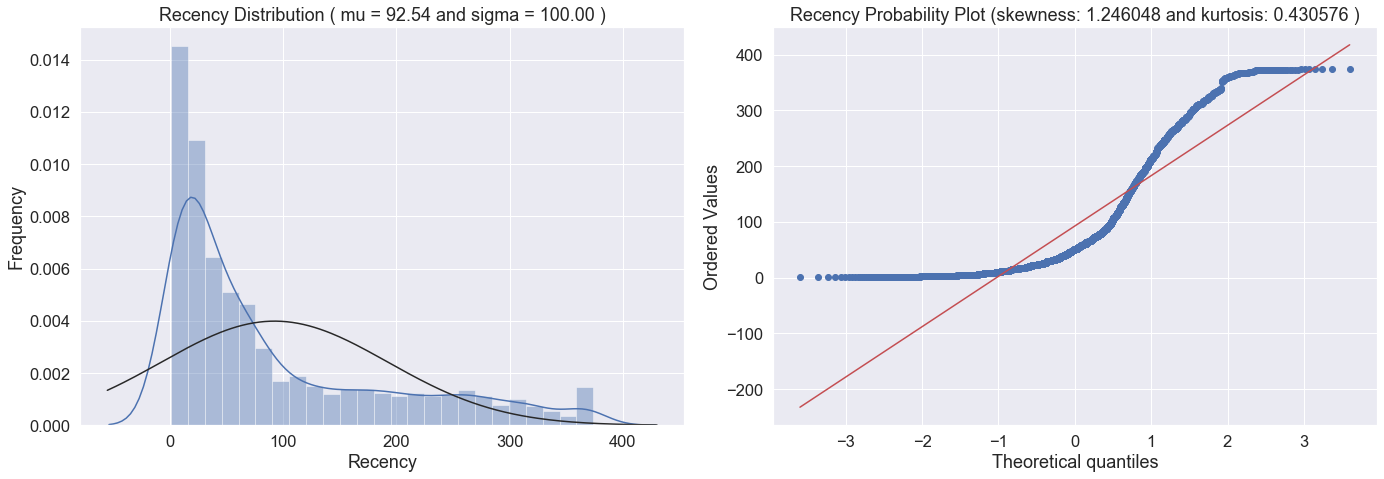

In [17]:


def QQ_plot(data, measure):
    fig = plt.figure(figsize=(20,7))

    #Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(data)

    #Kernel Density plot
    fig1 = fig.add_subplot(121)
    sns.distplot(data, fit=norm)
    fig1.set_title(measure + ' Distribution ( mu = {:.2f} and sigma = {:.2f} )'.format(mu, sigma), loc='center')
    fig1.set_xlabel(measure)
    fig1.set_ylabel('Frequency')

    #QQ plot
    fig2 = fig.add_subplot(122)
    res = probplot(data, plot=fig2)
    fig2.set_title(measure + ' Probability Plot (skewness: {:.6f} and kurtosis: {:.6f} )'.format(data.skew(), data.kurt()), loc='center')

    plt.tight_layout()
    plt.show()

QQ_plot(customer_history_df.recency, 'Recency')



From the first graph above we can see that sales recency distribution is skewed, has a peak on the left and a long tail to the right. It deviates from normal distribution and is positively biased.

From the Probability Plot, we could see that sales recency also does not align with the diagonal red line which represent normal distribution. The form of its distribution confirm that is a skewed right.

With skewness positive of 1.25, we confirm the lack of symmetry and indicate that sales recency are skewed right, as we can see too at the Sales Distribution plot, skewed right means that the right tail is long relative to the left tail. The skewness for a normal distribution is zero, and any symmetric data should have a skewness near zero. A distribution, or data set, is symmetric if it looks the same to the left and right of the center point.

Kurtosis is a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution. That is, data sets with high kurtosis tend to have heavy tails, or outliers, and positive kurtosis indicates a heavy-tailed distribution and negative kurtosis indicates a light tailed distribution. So, with 0.43 of positive kurtosis sales recency are heavy-tailed and has some outliers.

#### Frequency

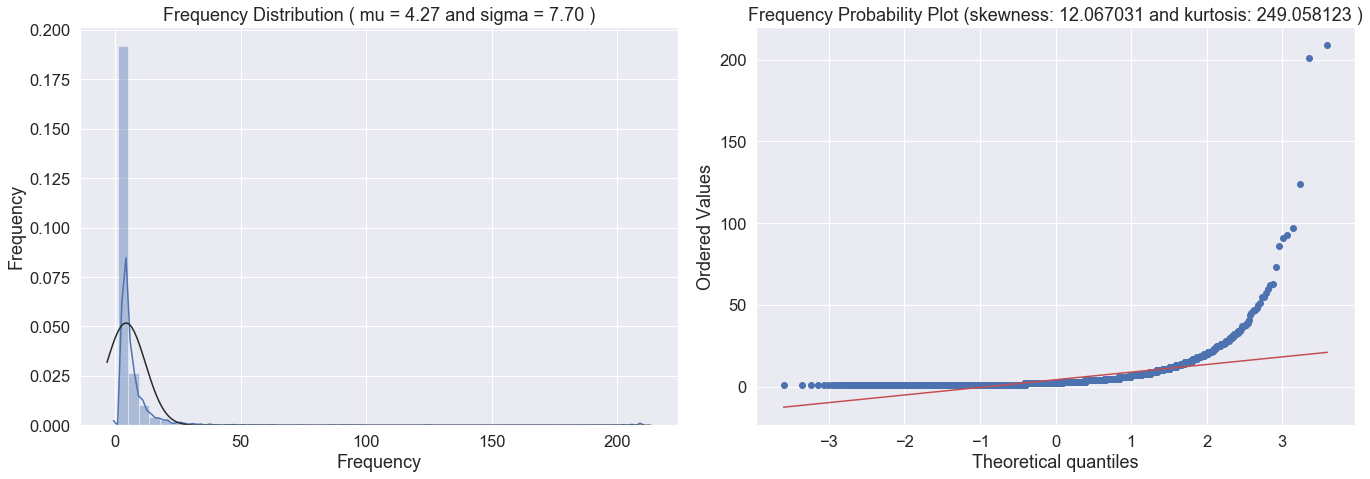

In [18]:
customer_freq = (cs_df[['CustomerID', 'InvoiceNo']].groupby(["CustomerID", 'InvoiceNo']).count().reset_index()).\
                groupby(["CustomerID"]).count().reset_index()
customer_freq.rename(columns={'InvoiceNo':'frequency'},inplace=True)
customer_history_df = customer_history_df.merge(customer_freq)
QQ_plot(customer_history_df.frequency, 'Frequency')



From the first graph above we can see that sales frequency distribution is skewed, has a peak on the left and a long tail to the right. It deviates from normal distribution and is positively biased.

From the Probability Plot, we could see that sales frequency also does **not align with the diagonal and confirm that is a skewed right.

With skewness positive of 12.1, we confirm the high lack of symmetry and with 249 Kurtosis indicates that is a heavy-tailed distribution and has outliers.

#### Monetary

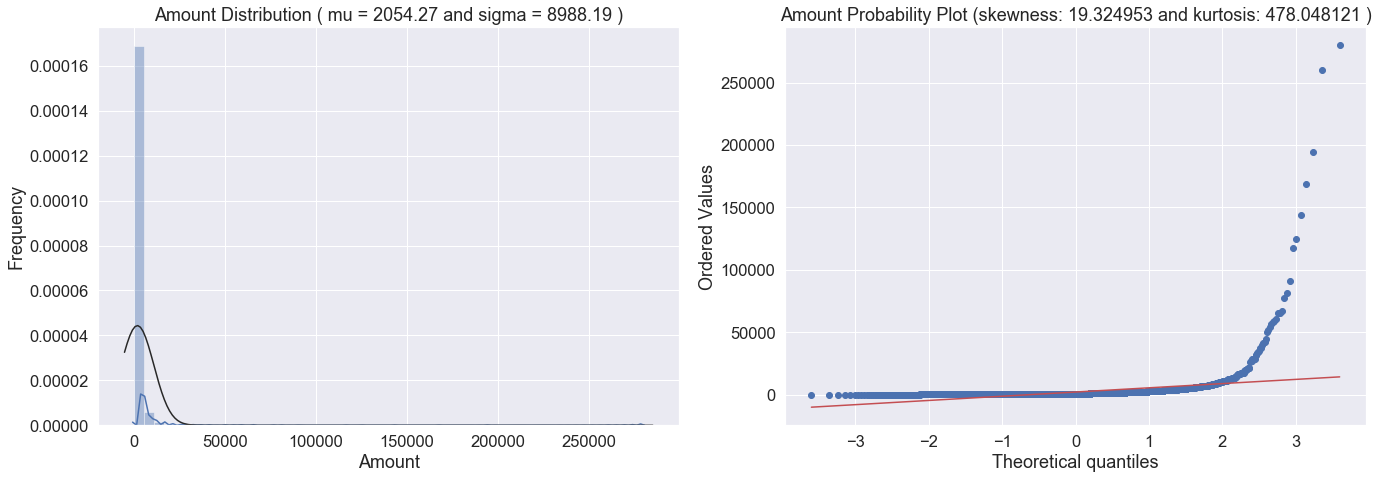

In [19]:
customer_monetary_val = cs_df[['CustomerID', 'amount']].groupby("CustomerID").sum().reset_index()
customer_history_df = customer_history_df.merge(customer_monetary_val)
QQ_plot(customer_history_df.amount, 'Amount')


From the first graph above we can see that sales amount distribution is skewed, has a peak on the left and a long tail to the right. It deviates from normal distribution and is positively biased.

From the Probability Plot, we could see that sales amount also does not align with the diagonal, special on the right.

With skewness positive of 19.3, we confirm the high lack of symmetry and with 478 Kurtosis indicates that is a too heavy-tailed distribution and has outliers, surely more than 10 very extreme.

Let's see a statistical summary of this dataset:

In [20]:
customer_history_df.describe()

,CustomerID,recency,frequency,amount
count,4338.000000,4338.000000,4338.000000,4338.000000
mean,15300.408022,92.536422,4.272015,2054.266460
std,1721.808492,100.014169,7.697998,8989.230441
min,12346.000000,1.000000,1.000000,3.750000
25%,13813.250000,18.000000,1.000000,307.415000
50%,15299.500000,51.000000,2.000000,674.485000
75%,16778.750000,142.000000,5.000000,1661.740000
max,18287.000000,374.000000,209.000000,280206.020000


#### Data Preprocessing
Once we have created our customer value dataset, we will perform some preprocessing on the data. For our clustering, we will be using the K-means clustering algorithm. One of the requirements for proper functioning of the algorithm is the mean centering of the variable values. Mean centering of a variable value means that we will replace the actual value of the variable with a standardized value, so that the variable has a mean of 0 and variance of 1. This ensures that all the variables are in the same range and the difference in ranges of values doesn't cause the algorithm to not perform well. This is akin to feature scaling.

Another problem that you can investigate about is the huge range of values each variable can take. This problem is particularly noticeable for the monetary amount variable. To take care of this problem, we will transform all the variables on the log scale. This transformation, along with the standardization, will ensure that the input to our algorithm is a homogenous set of scaled and transformed values.

An important point about the data preprocessing step is that sometimes we need it to be reversible. In our case, we will have the clustering results in terms of the log transformed and scaled variable. But to make inferences in terms of the original data, we will need to reverse transform all the variable so that we get back the actual RFM figures. This can be done by using the preprocessing capabilities of Python.

In [21]:
customer_history_df['recency_log'] = customer_history_df['recency'].apply(math.log)
customer_history_df['frequency_log'] = customer_history_df['frequency'].apply(math.log)
customer_history_df['amount_log'] = customer_history_df['amount'].apply(math.log)
feature_vector = ['amount_log', 'recency_log','frequency_log']
X_subset = customer_history_df[feature_vector] #.as_matrix()
scaler = preprocessing.StandardScaler().fit(X_subset)
X_scaled = scaler.transform(X_subset)
pd.DataFrame(X_scaled, columns=X_subset.columns).describe().T

,count,mean,std,min,25%,50%,75%,max
amount_log,4338.0,-1.202102e-16,1.000115,-4.179280,-0.684183,-0.060942,0.654244,4.721395
recency_log,4338.0,-1.027980e-16,1.000115,-2.630445,-0.612424,0.114707,0.829652,1.505796
frequency_log,4338.0,-2.355833e-16,1.000115,-1.048610,-1.048610,-0.279044,0.738267,4.882714


In [22]:
customer_history_df[customer_history_df['recency']==1]

,CustomerID,recency,frequency,amount,recency_log,frequency_log,amount_log
61,12423,1.0,8,1859.31,0.0,2.079442,7.527961
71,12433,1.0,7,13375.87,0.0,1.945910,9.501208
137,12518,1.0,5,2056.89,0.0,1.609438,7.628950
144,12526,1.0,3,1316.66,0.0,1.098612,7.182854
258,12662,1.0,11,3849.78,0.0,2.397895,8.255771
...,...,...,...,...,...,...,...
3894,17675,1.0,31,20374.28,0.0,3.433987,9.922029
3954,17754,1.0,5,1772.26,0.0,1.609438,7.480011
3955,17757,1.0,30,5605.29,0.0,3.401197,8.631466
4093,17949,1.0,45,58510.48,0.0,3.806662,10.976961


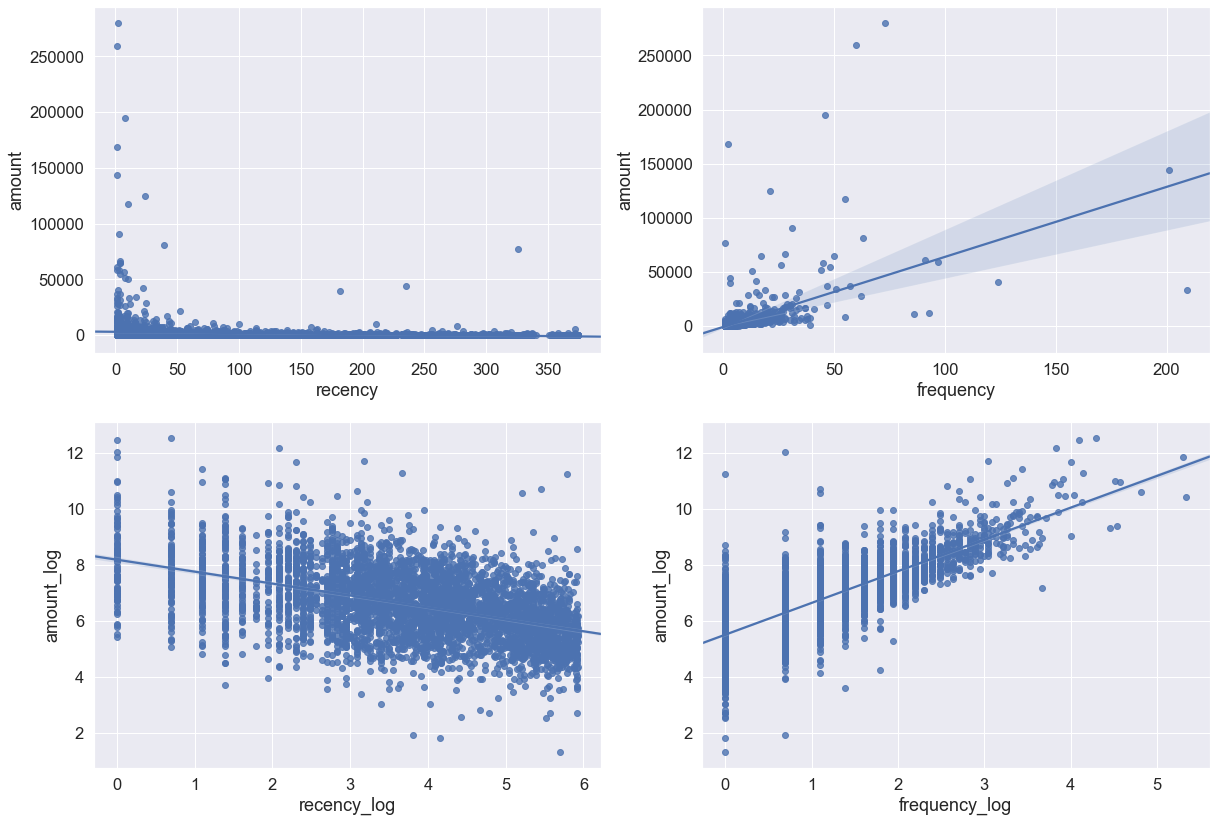

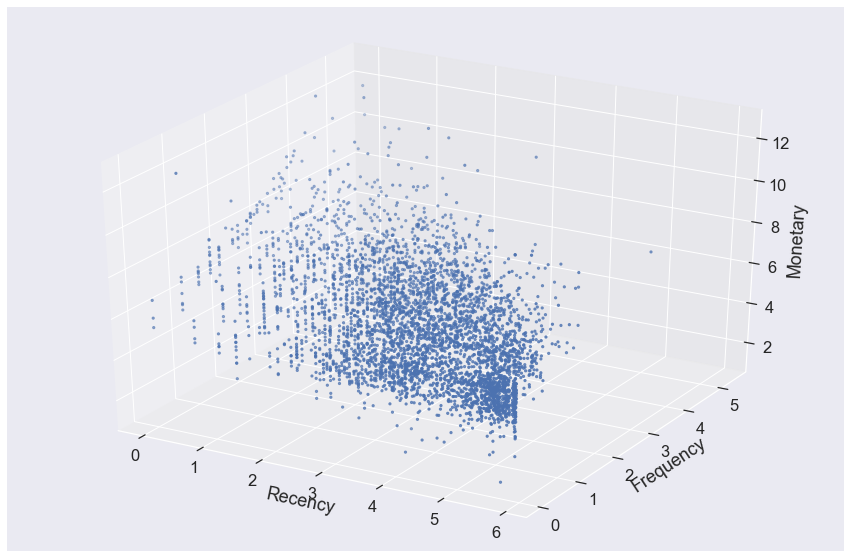

In [23]:
fig = plt.figure(figsize=(20,14))
f1 = fig.add_subplot(221); sns.regplot(x='recency', y='amount', data=customer_history_df)
f1 = fig.add_subplot(222); sns.regplot(x='frequency', y='amount', data=customer_history_df)
f1 = fig.add_subplot(223); sns.regplot(x='recency_log', y='amount_log', data=customer_history_df)
f1 = fig.add_subplot(224); sns.regplot(x='frequency_log', y='amount_log', data=customer_history_df)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

xs =customer_history_df.recency_log
ys = customer_history_df.frequency_log
zs = customer_history_df.amount_log
ax.scatter(xs, ys, zs, s=5)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

plt.show()

The obvious patterns we can see from the plots above is that costumers who buy with a higher frequency and more recency tend to spend more based on the increasing trend in Monetary (amount value) with a corresponding increasing and decreasing trend for Frequency and Recency, respectively.

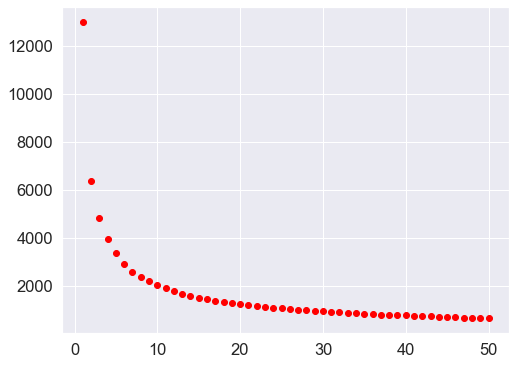

The best K sugest:  7


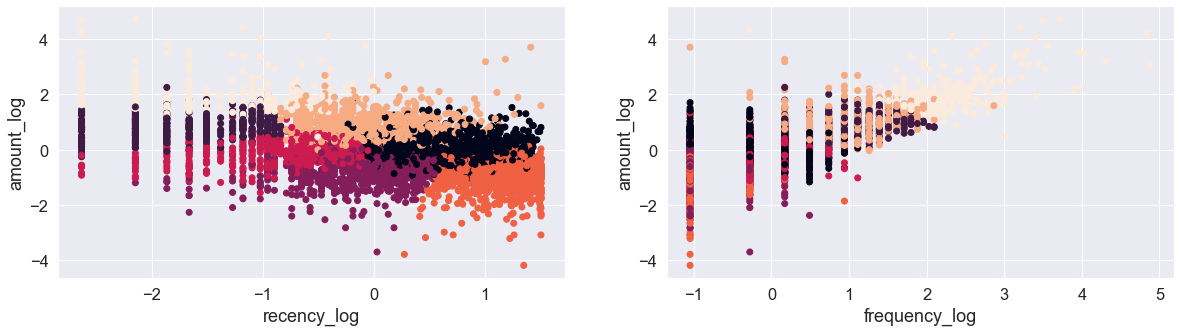

In [24]:
cl = 50
corte = 0.1

anterior = 100000000000000
cost = [] 
K_best = cl

for k in range (1, cl+1):
    # Create a kmeans model on our data, using k clusters.  random_state helps ensure that the algorithm returns the same results each time.
    model = KMeans(
        n_clusters=k, 
        init='k-means++', #'random',
        n_init=10,
        max_iter=300,
        tol=1e-04,
        random_state=101)

    model = model.fit(X_scaled)

    # These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
    labels = model.labels_
 
    # Sum of distances of samples to their closest cluster center
    interia = model.inertia_
    if (K_best == cl) and (((anterior - interia)/anterior) < corte): K_best = k - 1
    cost.append(interia)
    anterior = interia

plt.figure(figsize=(8, 6))
plt.scatter(range (1, cl+1), cost, c='red')
plt.show()

# Create a kmeans model with the best K.
print('The best K sugest: ',K_best)
model = KMeans(n_clusters=K_best, init='k-means++', n_init=10,max_iter=300, tol=1e-04, random_state=101)

# Note I'm scaling the data to normalize it! Important for good results.
model = model.fit(X_scaled)

# These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
labels = model.labels_

# And we'll visualize it:
#plt.scatter(X_scaled[:,0], X_scaled[:,1], c=model.labels_.astype(float))
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(121)
plt.scatter(x = X_scaled[:,1], y = X_scaled[:,0], c=model.labels_.astype(float))
ax.set_xlabel(feature_vector[1])
ax.set_ylabel(feature_vector[0])
ax = fig.add_subplot(122)
plt.scatter(x = X_scaled[:,2], y = X_scaled[:,0], c=model.labels_.astype(float))
ax.set_xlabel(feature_vector[2])
ax.set_ylabel(feature_vector[0])

plt.show()

Note that by the Elbow method from a K equal to 3 we already observed low rates of gain in the decay of the distortions with the decrease of K reaching the limit of 10% with the K equal to 7. With this in mind, we will begin to evaluate the options more deeply with 3, and 7, starting with the silhouette analysis.

#### Silhouette analysis on K-Means clustering
Silhouette analysis can be used to study the separation distance between the resulting clusters, as a strategy to quantifying the quality of clustering via graphical tool to plot a measure of how tightly grouped the samples in the clusters are. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually.

It can also be applied to clustering algorithms other than k-means

Silhouette coefficients has a range of [-1, 1], it calculated by:

1. Calculate the cluster cohesion a( i )as the average distance between a sample x( i ) and all other points in the same cluster.
2. Calculate the cluster separation b( i ) from the next closest cluster as the average distance between the sample x( i ) and all samples in the nearest cluster.
3. Calculate the silhouette s( i ) as the difference between cluster cohesion and separation divided by the greater of the two.

The silhouette plot can shows a bad K clusters pick for the given data due to the presence of clusters with below average silhouette scores and also due to wide fluctuations in the size of the silhouette plots. A good k clusters can found when all the plots are more or less of similar thickness and hence are of similar sizes.

Although we have to keep in mind that in several cases and scenarios, sometimes we may have to drop the mathematical explanation given by the algorithm and look at the business relevance of the results obtained.

Let's see below how our data perform for each K clusters groups (3, 5 and 7) in the silhouette score of each cluster, along with the center of each of the cluster discovered in the scatter plots, by amount_log vs recency_log and vs frequency_log.

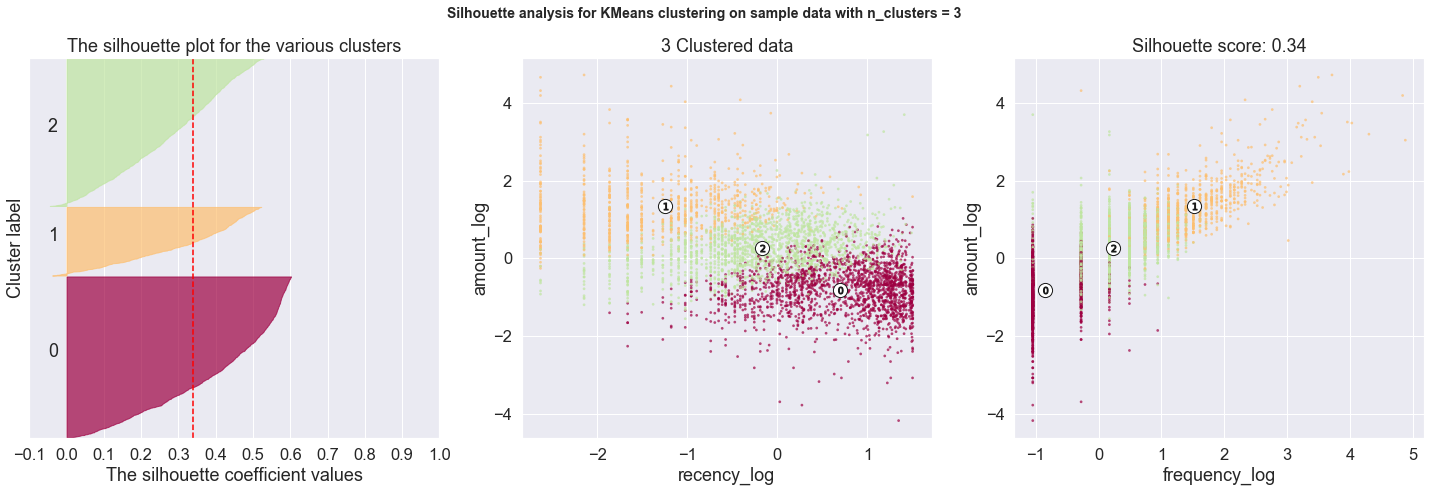

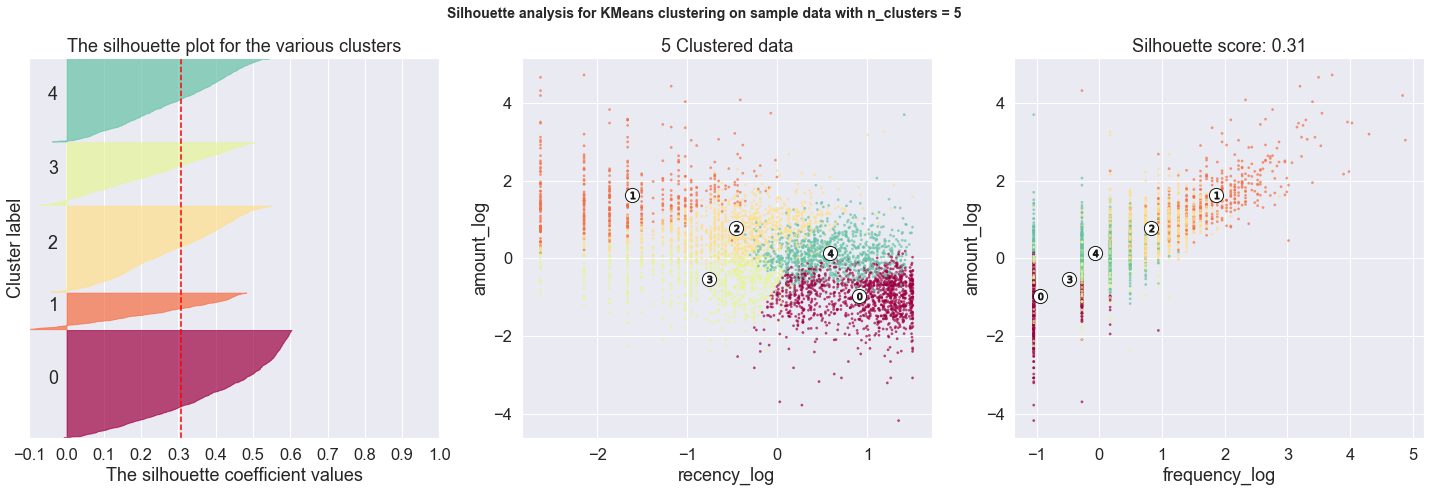

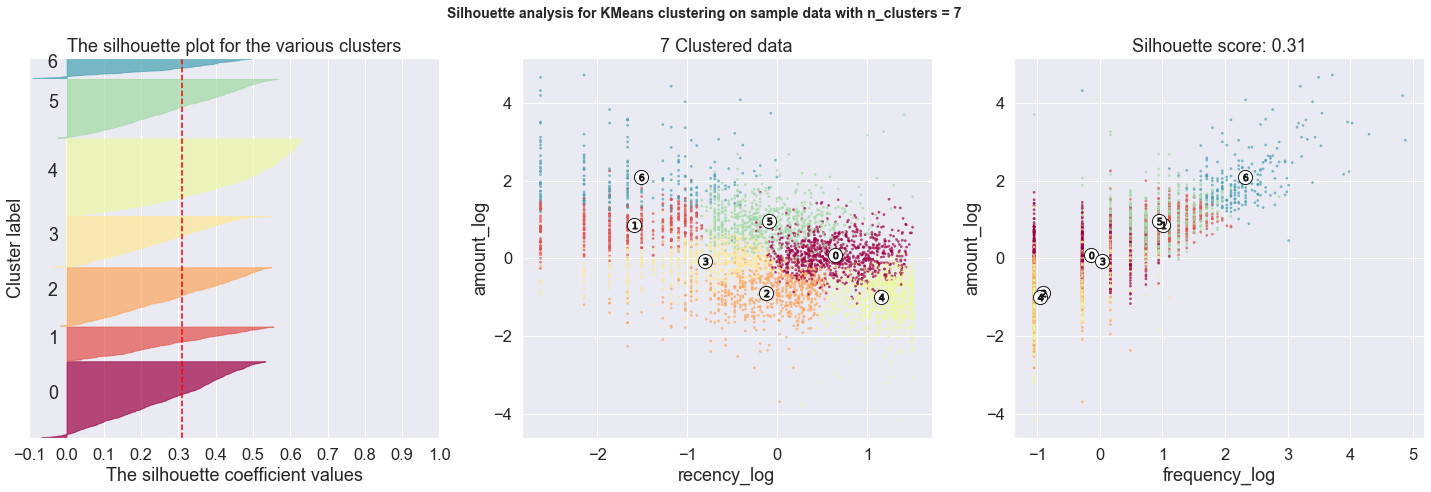

In [25]:
cluster_centers = dict()

for n_clusters in range(3,K_best+1,2):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_size_inches(25, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X_scaled) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10,max_iter=300, tol=1e-04, random_state=101)
    cluster_labels = clusterer.fit_predict(X_scaled)

    silhouette_avg = silhouette_score(X = X_scaled, labels = cluster_labels)
    cluster_centers.update({n_clusters :{'cluster_center':clusterer.cluster_centers_,
                                         'silhouette_score':silhouette_avg,
                                         'labels':cluster_labels}
                           })

    sample_silhouette_values = silhouette_samples(X = X_scaled, labels = cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.Spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
    colors = cm.Spectral(cluster_labels.astype(float) / n_clusters)
    
    centers = clusterer.cluster_centers_
    y = 0
    x = 1
    ax2.scatter(X_scaled[:, x], X_scaled[:, y], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')   
    ax2.scatter(centers[:, x], centers[:, y], marker='o', c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[x], c[y], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
    ax2.set_title("{} Clustered data".format(n_clusters))
    ax2.set_xlabel(feature_vector[x])
    ax2.set_ylabel(feature_vector[y])

    x = 2
    ax3.scatter(X_scaled[:, x], X_scaled[:, y], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')   
    ax3.scatter(centers[:, x], centers[:, y], marker='o', c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax3.scatter(c[x], c[y], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
    ax3.set_title("Silhouette score: {:1.2f}".format(cluster_centers[n_clusters]['silhouette_score']))
    ax3.set_xlabel(feature_vector[x])
    ax3.set_ylabel(feature_vector[y])
    
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()

When we look at the results of the clustering process, we can infer some interesting insights:

First notice that all K clusters options is valid, because they don't have presence of clusters with below average silhouette scores.
In the other hand, all options had a some wide fluctuations in the size of the silhouette plots.
So, the best choice may lie on the option that gives us a simpler business explanation and at the same time target customers in focus groups with sizes closer to the desired.

Clusters Center:
Let's look at the cluster center values after returning them to normal values from the log and scaled version

In [26]:
features = ['amount',  'recency',  'frequency']
for i in range(3,K_best+1,2):
    print("for {} clusters the silhouette score is {:1.2f}".format(i, cluster_centers[i]['silhouette_score']))
    print("Centers of each cluster:")
    cent_transformed = scaler.inverse_transform(cluster_centers[i]['cluster_center'])
    print(pd.DataFrame(np.exp(cent_transformed),columns=features))
    print('-'*50)

for 3 clusters the silhouette score is 0.34
Centers of each cluster:
        amount     recency  frequency
0   261.952265  116.604917   1.190876
1  3967.994380    7.236580  10.044493
2  1006.914317   33.819966   3.152227
--------------------------------------------------
for 5 clusters the silhouette score is 0.31
Centers of each cluster:
        amount     recency  frequency
0   213.876290  159.060239   1.088129
1  5708.668108    4.285608  13.677542
2  1929.872406   22.442129   5.413014
3   372.314665   14.590855   1.665686
4   863.093356  100.092666   2.395562
--------------------------------------------------
for 7 clusters the silhouette score is 0.31
Centers of each cluster:
         amount     recency  frequency
0    809.713152  107.590047   2.277095
1   2115.751105    4.436558   6.395614
2    239.805507   36.372861   1.132543
3    667.345658   13.698858   2.663541
4    205.016462  225.462781   1.082459
5   2414.804796   38.026754   6.003854
6  10182.351681    4.961015  20.687947

#### Clusters Insights:
With the plots and the center in the correct units, let's see some insights by each clusters groups:

#### In the three-cluster:

1. The tree clusters appears have a good stark differences in the Monetary value of the customer, we will confirm this by a box plot.
2. Cluster 1 is the cluster of high value customer who shops frequently and is certainly an important segment for each business.
3. In the similar way we obtain customer groups with low and medium spends in clusters with labels 0 and 2, respectively.
4. Frequency and Recency correlate perfectly to the Monetary value based on the trend (High Monetary-Low Recency-High Frequency).

#### In the five-cluster:

Note that clusters 0 and 1 are very similar to their cluster in the configuration with only 3 clusters.

1. The cluster 1 appears more robust on the affirmation of those who shop often and with high amount.
2. The cluster 2 are those who have a decent spend but are not as frequent as the cluster 1
3. The cluster 4 purchases medium amounts, with a relatively low frequency and not very recent
4. The cluster 3 makes low-cost purchases, with a relatively low frequency, but above 1, and made their last purchase more recently. This group of customers probably response to price discounts and can be subject to loyalty promotions to try increase the medium-ticket, strategy that can be better defined when we analyzing the market basket.

The silhouette score matrix says that the five cluster segments are less optimal then the three cluster segments.
In the five-cluster:

Definitely cluster 6 defines those who shop often and with high amount.

1. Clusters 1 and 5 show good spending and good frequency, only deferring in how recent were their last purchases, where 5 is older, which suggests an active action to sell to group 5 as soon as possible and another to 1 seeking to raise its frequency.
2. Cluster 0 presents the fourth best purchase and a reasonable frequency, but this is a long time without buying. This group should be sensible to promotions and activations, so that they do not get lost and make their next purchase.
3. Cluster 5 is similar to 0, but has made its purchases more recently and has a slightly better periodicity. Then actions must be taken to raise their frequency and reduce the chances of them migrating to cluster 0 by staying longer without purchasing products.

#### Drill Down Clusters:
To further drill down on this point and find out the quality of these difference, we can label our data with the corresponding cluster label and then visualize these differences. The following code will extract the clustering label and attach it with our customer summary dataset.

,CustomerID,recency,frequency,amount,recency_log,frequency_log,amount_log,clusters_3,clusters_5,clusters_7
0,12346,326.0,1,77183.60,5.786897,0.000000,11.253942,2,4,5
1,12347,2.0,7,4310.00,0.693147,1.945910,8.368693,1,1,1
2,12348,75.0,4,1797.24,4.317488,1.386294,7.494007,2,4,5
3,12349,19.0,1,1757.55,2.944439,0.000000,7.471676,2,3,3
4,12350,310.0,1,334.40,5.736572,0.000000,5.812338,0,0,4


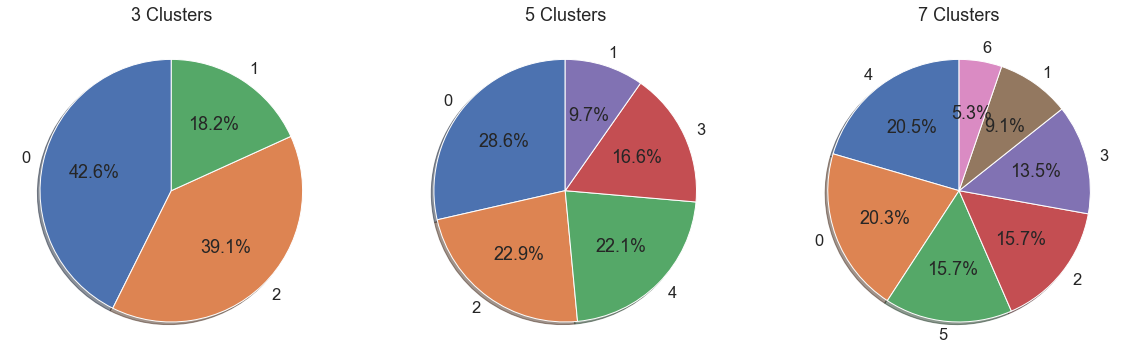

In [27]:
customer_history_df['clusters_3'] = cluster_centers[3]['labels'] 
customer_history_df['clusters_5'] = cluster_centers[5]['labels']
customer_history_df['clusters_7'] = cluster_centers[7]['labels']
display(customer_history_df.head())

fig = plt.figure(figsize=(20,7))
f1 = fig.add_subplot(131)
market = customer_history_df.clusters_3.value_counts()
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('3 Clusters')
f1 = fig.add_subplot(132)
market = customer_history_df.clusters_5.value_counts()
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('5 Clusters')
f1 = fig.add_subplot(133)
market = customer_history_df.clusters_7.value_counts()
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('7 Clusters')
plt.show()

Once we have the labels assigned to each of the customers, our task is simple. Now we want to find out how the summary of customer in each group is varying. If we can visualize that information we will able to find out the differences in the clusters of customers and we can modify our strategy on the basis of those differences.

The following code leverages plotly and will take the cluster labels we got for each configurations clusters and create boxplots. Plotly enables us to interact with the plots to see the central tendency values in each boxplot in the notebook. Note that we want to avoid the extremely high outlier values of each group, as they will interfere in making a good observation around the central tendencies of each cluster. Since we have only positive values, we will restrict the data such that only data points which are less than 0.95th percentile of the cluster is used. This will give us good information about the majority of the users in that cluster segment.